In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import scipy.optimize
from IPython.display import clear_output
import time
import os

In [2]:
# simulation parameters to run
repeats       = 10000      # 10000
batch_size    = 10000      # 10000

subset_size   = 60         # 9 for 95%, 90 for 50%, 60 for 66%
geometry      ='sphere'    # sphere/floor
behavior_DOFs = 3          # 6, 3, or 1
noiselevel    = 0.25       # 0.0 or 0.10 or 0.25
spatvarnoise  = True       # if true, noise varies by elevation

In [3]:
# make grid of azimuth (theta) and elevation (alpha) coordinates of arbitrary resolution
res = 20
    
# full res
theta_mat,alpha_mat = np.meshgrid(np.linspace(-np.pi,np.pi,int(res),endpoint=False),
                                np.linspace(-np.pi/2,np.pi/2,int(res/2),endpoint=False))

# flatten matrices
thetas = theta_mat.flatten()
alphas = alpha_mat.flatten()

# remove points where alpha = -pi/2
thetas = thetas[alphas > -np.pi/2]
alphas = alphas[alphas > -np.pi/2]

sparselevel = 1 - subset_size/np.size(thetas)

print('sparsity level',sparselevel)

sparsity level 0.6666666666666667


In [4]:
# function for determining scene depth geometry
def nearness(geometry='sphere',theta=thetas,alpha=thetas,r=1):
    if geometry == 'sphere':
        mu = 1/r*np.ones_like(theta)
    elif geometry == 'floor':
        mu = np.abs(np.sin(alpha))/r * (alpha < 0)
    return mu

# function that generates optical flow field at a sec of azimuths/elevations for a given self-motion trajectory/geometry
# equations slightly modified (signs and axis labels changed) from
# eqn 2.13 and following matrices in
# http://www.cds.caltech.edu/~murray/preprints/humbert05-phd.pdf
def tangentialflow(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,geometry='sphere',theta=thetas,alpha=thetas,r=1,theta0=0,alpha0=0):
    mu = nearness(geometry=geometry,theta=theta,alpha=alpha,r=r)
    flow_horiz = -np.sin(alpha)*np.cos(theta)*Wz + \
                 np.sin(alpha)*np.sin(theta)*Wx + \
                 -np.cos(alpha)*Wy + \
                 mu*(np.sin(theta)*Vz + np.cos(theta)*Vx)
    flow_vert = np.sin(theta)*Wz + \
                np.cos(theta)*Wx + \
                mu*(np.sin(alpha)*np.cos(theta)*Vz + \
                          -np.sin(alpha)*np.sin(theta)*Vx + \
                          np.cos(alpha)*Vy)
    return flow_horiz, flow_vert


In [5]:
# predict velocity from flow with weighted least squares
def getvel(flow,theta=thetas,alpha=alphas,geometry='sphere',DOFs=6,weights=0):
    
    # if no weights were given, assume uniform
    if np.size(weights) == 1:
        weights=np.ones(len(theta))
        
    vxtemplate = np.ndarray.flatten(np.array(tangentialflow(Vx=1,theta=theta,alpha=alpha,geometry=geometry)))
    vytemplate = np.ndarray.flatten(np.array(tangentialflow(Vy=1,theta=theta,alpha=alpha,geometry=geometry)))
    vztemplate = np.ndarray.flatten(np.array(tangentialflow(Vz=1,theta=theta,alpha=alpha,geometry=geometry)))
    wxtemplate = np.ndarray.flatten(np.array(tangentialflow(Wx=1,theta=theta,alpha=alpha,geometry=geometry)))
    wytemplate = np.ndarray.flatten(np.array(tangentialflow(Wy=1,theta=theta,alpha=alpha,geometry=geometry)))
    wztemplate = np.ndarray.flatten(np.array(tangentialflow(Wz=1,theta=theta,alpha=alpha,geometry=geometry)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred = np.zeros([6,1])
    pred_DOF,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    
    if DOFs == 1:
        pred[2] = pred_DOF
    elif DOFs == 3:
        pred[0] = pred_DOF[0]  
        pred[2] = pred_DOF[1]  
        pred[4] = pred_DOF[2]  
    elif DOFs == 6:
        pred = pred_DOF
    return np.squeeze(pred)


def anglediff(a,b,deg=True):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))


In [6]:
# for a given set of indices (x), runs a batch of self motion trajectories and calculates the errors
# x is a set of indices to use to subset theta/alpha
def error_calc(x,trials=10,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False,weights=0):

    preds = np.nan*np.ones([trials,6])
    gt = np.nan*np.ones([trials,6])
    
    # subset
    this_subset_thetas = thetas[x]
    this_subset_alphas = alphas[x]

    for i in range(trials): 
        
        # generate random behavior (uniform from -1 to 1)
        Vx,Vy,Vz,Wx,Wy,Wz = 2*np.random.rand(6) - 1
        
        # zero out irrelevant DOFs
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        flow = tangentialflow(geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            noise = noise*((np.tile(-this_subset_alphas,[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise
        
        if plotit == True:
            plt.quiver(this_subset_thetas,this_subset_alphas,flow[0],flow[1],scale=10,color='r')
                
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
    
            plt.savefig(f'./plots/example_global_flow_{i}.eps', format='eps')
        
        # get error
        gt[i,:] = [Vx,Vy,Vz,Wx,Wy,Wz]
        preds[i,:] = getvel(flow,geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,DOFs=DOFs,weights=weights)
    
    # return average error (in meters or radians)
    errs = np.median(np.abs(preds-gt),0)
    err_Vz = errs[2]
    
    # heading error (in radians)
    headinggt = np.arctan2(gt[...,0],gt[...,2])
    headingpred = np.arctan2(preds[...,0],preds[...,2])
    headingerr = np.median(np.abs(anglediff(headingpred,headinggt,deg=False)))
    
    errs = np.append(errs,headingerr)
    
    #return err_Vz
    return errs

In [7]:
# check that error calculation runs
this_subset_inds = np.random.randint(0, high=int(np.size(thetas)), size=int(subset_size))
error_calc(this_subset_inds,trials=1000,noiselevel=0.05,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=spatvarnoise)

array([0.00283572, 0.00328232, 0.00349576, 0.00284905, 0.00311564,
       0.00339637, 0.00447532])

In [8]:
# check for existing files to determine number of repeats left to run

if spatvarnoise == False:
    file_starter = f'global_{subset_size}nsamples_{noiselevel}noise_{geometry}_{behavior_DOFs}DOFs_{batch_size}batchsize'
elif spatvarnoise == True:
    file_starter = f'global_{subset_size}nsamples_{noiselevel}noise_spatiallyvaryingnoise_{geometry}_{behavior_DOFs}DOFs_{batch_size}batchsize'
    
repeats_left = repeats
for file in os.listdir('./global_simulation_files'):
    if file.startswith(file_starter):
        print(file)
        data = np.load('./global_simulation_files/'+file)
        repeats_left = repeats_left - data['repeats']
        print("Num repeats already done = ",data['repeats'])
        print("Num repeats remaining = ",repeats_left)

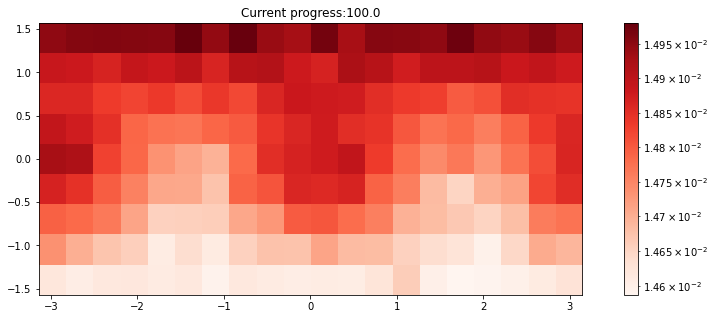

In [9]:
# run sim a bunch of times

# initialize results        
all_subset_inds = np.ones([repeats_left,subset_size],dtype = np.int16)
all_err_Vz      = np.zeros(repeats_left)
all_err         = np.zeros([repeats_left,7])
running_sum     = np.zeros_like(thetas)
running_count   = np.zeros_like(thetas)

timestr = time.strftime("%Y%m%d-%H%M%S")

for i in range(repeats_left):
    
    this_subset_inds = np.random.randint(0, high=int(np.size(thetas)), size=int(subset_size))
    all_subset_inds[i,:] = this_subset_inds
    
    errs = error_calc(this_subset_inds,trials=batch_size,noiselevel=noiselevel,geometry=geometry,theta=thetas,alpha=alphas,DOFs=behavior_DOFs,spatvarnoise=spatvarnoise)
    err_Vz = errs[2]
    all_err[i,:] = errs
    all_err_Vz[i] = err_Vz

    running_sum[this_subset_inds] = running_sum[this_subset_inds] + err_Vz
    running_count[this_subset_inds] = running_count[this_subset_inds] + 1
    
    # visualize intermediate results
    if np.mod(i+1,100) == 0 or i+1 == repeats_left:
        
        # calculate weighted average
        weighted_average = running_sum/running_count
        
        clear_output(wait=True)
        
        # plot weighted average
        plt.figure(figsize=(15,5))
        plt.title(f'Current progress:{np.round(100*(i+1)/(repeats_left),2)}')
        heatmap = np.reshape(weighted_average,[9,20])
        plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],norm=colors.LogNorm(),aspect=1)
        # to set color limit use e.g. norm=colors.LogNorm((vmin=1,vmax=5)) in line above
        plt.colorbar()

        plt.show()
        
        if spatvarnoise == False:
            np.savez(f'./global_simulation_files/global_{sparselevel*100:.0f}pctsparse_{noiselevel}noise_{geometry}_{behavior_DOFs}DOFs_{batch_size}batchsize_{repeats_left}repeats_{timestr}',repeats=i+1,batch_size=batch_size,subset_size=subset_size,thetas=thetas,alphas=alphas,all_subset_inds=all_subset_inds,all_err=all_err,all_err_Vz=all_err_Vz,running_sum=running_sum,running_count=running_count,weighted_average=weighted_average)
        elif spatvarnoise == True:
            np.savez(f'./global_simulation_files/global_{sparselevel*100:.0f}pctsparse_{noiselevel}noise_spatiallyvaryingnoise_{geometry}_{behavior_DOFs}DOFs_{batch_size}batchsize_{repeats_left}repeats_{timestr}',repeats=i+1,batch_size=batch_size,subset_size=subset_size,thetas=thetas,alphas=alphas,all_subset_inds=all_subset_inds,all_err=all_err,all_err_Vz=all_err_Vz,running_sum=running_sum,running_count=running_count,weighted_average=weighted_average)
